To be run after the vector database is loaded (using script in generate_embeddings.ipynb)

In [1]:
from datetime import datetime
import pandas as pd
import requests
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from InstructorEmbedding import INSTRUCTOR

import weaviate
import json
import os
from dotenv import load_dotenv


load_dotenv()
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
weaviate_api_key = os.getenv('WEAVIATE_API_KEY')
weaviate_url = os.getenv('WEAVIATE_URL')
openai_key = os.getenv('OPENAI_KEY')
billtrack50_api_key = os.getenv('bill_tracker_api_key')

client = weaviate.Client(
    url = weaviate_url,
    auth_client_secret=weaviate.AuthApiKey(api_key=weaviate_api_key), 
    additional_headers = {
        "X-OpenAI-Api-Key": openai_key
    }
)

Python(94395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/karenwang/.virtualenvs/semantic-search/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/karenwang/.virtualenvs/semantic-search/lib/python3.11/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.2. The latest version is 4.5.6.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


In [ ]:
# model = SentenceTransformer('sentence-transformers/msmarco-MiniLM-L12-cos-v5')
model = INSTRUCTOR('hkunlp/instructor-large')

general_query = """
Rerank based on the bill's relevance to and impact on to the LGBTQ+ community, including mentions of gender expressions, sexual orientation, sexual identify, lesbian, gay, transgender, bisexual, nonbinary, gender-nonconforming, pronouns, gender identity, genderqueer, genderfluid, Sex reassignment, gender reassignment, Biological sex, Natural sex hormones, Sex organs etc.
"""
anti_trans_query = """
Find bills that explicitly or implicitly harm or violate the rights of transgender people. 
"""
query_text = general_query
instruction_prompt = "Represent the legislation bill for retrieval:"
generate_prompt = "Summarize the following highlighting its impact on LGBTQ community: {{billText}}, and explain when it was created: {{created}}, and its current status: {{status}}."
query_prompt = "Represent the user question for question answering:"

# query_vector = model.encode(query_text).tolist()
query_vector = model.encode([[query_prompt,query_text]]).tolist()
query_vector = [item for sublist in query_vector for item in sublist]
state = "MO"
limit = 50
get_legislation_group = f"""
{{
  Get {{
    Legislation_instructor(
      where: {{
        path: ["stateCode"],
        operator: Equal,
        valueString: "{state}"
      }},
      nearVector: {{
        vector: {query_vector}
      }},
      group: {{
        type: merge,
        force: 0
      }},
      limit: {limit}
    ) {{
      billID
      stateCode
      stateBillID
      shortBillName
      statesummary
      billText
      sponsorParty
      billtype
      status
      created
      # _additional {{
      #   generate(
      #     groupedResult: {{
      #       task: "Summarize the following highlighting its impact on LGBTQ community: {{billText}}, and explain when it was created: {{created}}, and its current status: {{status}}."
      #     }}
      #   ) {{
      #     singleResult
      #     error
      #   }}
      # }}
    }}
  }}
}}
"""

# where_filter = {
#   "path": ["stateCode"],
#   "operator": "Equal",
#   "valueString": f"{state}"
# }

# query_result = (
#   client.query
#   .get("Legislation_instructor", ["billID", "stateCode", "stateBillID", "shortBillName", "statesummary", "billText", "sponsorParty", "billtype", "status", "created"])
#   .with_where(where_filter)
#   # .with_generate(single_prompt=generate_prompt)
#   .with_near_vector({
#     "vector": query_vector
#   })
#   .with_limit(5)
# ).do()

# processed_result = generate(query_result, single_prompt=generate_prompt)


# print(processed_result)


query_result = client.query.raw(get_legislation_group)
print(query_result)
# # save to csv
df = pd.DataFrame(query_result['data']['Get']['Legislation_instructor'])
df.to_csv(f'../data_storage/{state}_weaviate_result_top_{limit}_rerank_instructor.csv', index=False)

In [122]:
mo_50 = pd.read_csv('../data_storage/legislation/MO_weaviate_result_top_50.csv')
mo_50['Label']
mo_50_rerank = pd.read_csv('../data_storage/MO_weaviate_result_top_50_rerank_instructor.csv')
merged_df = pd.merge(mo_50_rerank, mo_50[['stateBillID', 'Label']], on='stateBillID', how='left')
merged_df.to_csv('../data_storage/legislation/MO_weaviate_result_top_50_rerank_label_instructor.csv', index=False)

     billID Final Label
0   1653041           Y
1   1660757           Y
2   1660644           M
3   1652697           Y
4   1652282           M
5   1653008           Y
6   1652226           Y
7   1652140           Y
8   1679871           Y
9   1652826           Y
10  1652949           Y
11  1652928           Y
12  1663671           Y
13  1665609           Y
14  1714350           Y
15  1652230           Y
16  1713734           Y
17  1716173          NR
18  1716021           M
19  1652776           M
20  1654756           Y
21  1657901           Y
22  1652598        DEAD
23  1689351          NR
24  1664234           Y
25  1657671           Y
26  1652722           Y
27  1677385           Y
28  1694195          NR
29  1714988           N
30  1670887           Y
31  1652651           N
32  1652455          NR
33  1711868           M
34  1658180          NR
35  1652757          NR
36  1652095           Y
37  1658591           M
38  1689675          NR
39  1652310           N
40  1685878     

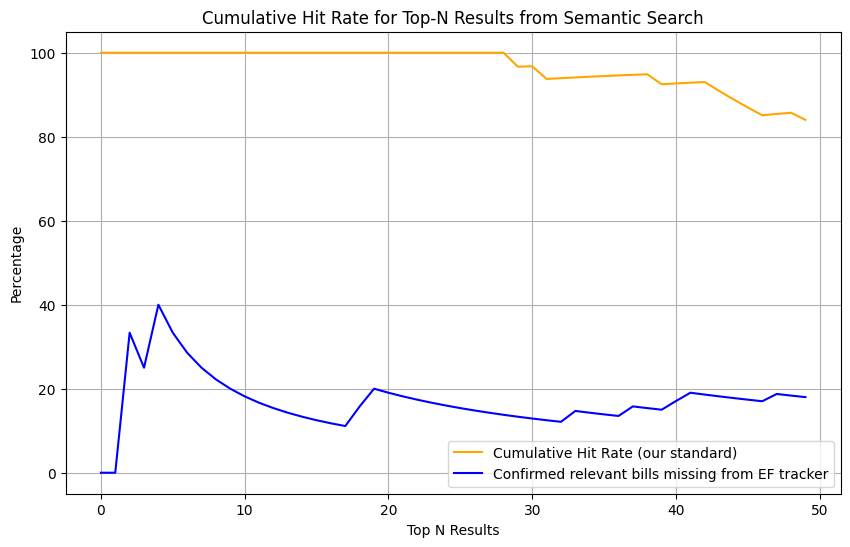

In [12]:
import pandas as pd
labeled = pd.read_csv('../data_storage/legislation/MO_weaviate_result_top_50_rerank_label_instructor.csv')

ef = pd.read_csv('../data_storage/legislation/EF-eval.csv')

result = pd.merge(labeled[['billID', 'Label']], ef[['billID', 'EF-label']], on='billID', how='left')

# Create a new column 'Final Label' which uses 'EF-label' if available, otherwise 'Label'
result['Final Label'] = result['EF-label'].fillna(result['Label'])

# Drop the now unnecessary 'Label' and 'EF-label' columns
result.drop(columns=['Label', 'EF-label'], inplace=True)

# Display the result
print(result)

import pandas as pd
import matplotlib.pyplot as plt

result['Cumulative Hit Rate'] = result['Final Label'].apply(lambda x: x in ['M', 'Y', 'NR', 'DEAD']).cumsum()
result['Cumulative Hit Rate'] = result['Cumulative Hit Rate'] / (result.index + 1) * 100  # Converting to percentage

# Calculate the cumulative percentage for M labels
result['Cumulative M Percentage'] = (result['Final Label'] == 'M').cumsum() / (result.index + 1) * 100

# Calculate the cumulative percentage for G-criteria (NR, DEAD, and M)
result['Cumulative G-criteria Percentage'] = result['Final Label'].apply(lambda x: x in ['M', 'NR', 'DEAD']).cumsum() / (result.index + 1) * 100

# Plotting the Cumulative Hit Rate and Confirmed Missing and Relevant Bills
plt.figure(figsize=(10, 6))
plt.plot(result['Cumulative Hit Rate'], label='Cumulative Hit Rate (our standard)', color='orange')
plt.plot(result['Cumulative M Percentage'], label='Confirmed relevant bills missing from EF tracker', color='blue')
plt.title('Cumulative Hit Rate for Top-N Results from Semantic Search')
plt.xlabel('Top N Results')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


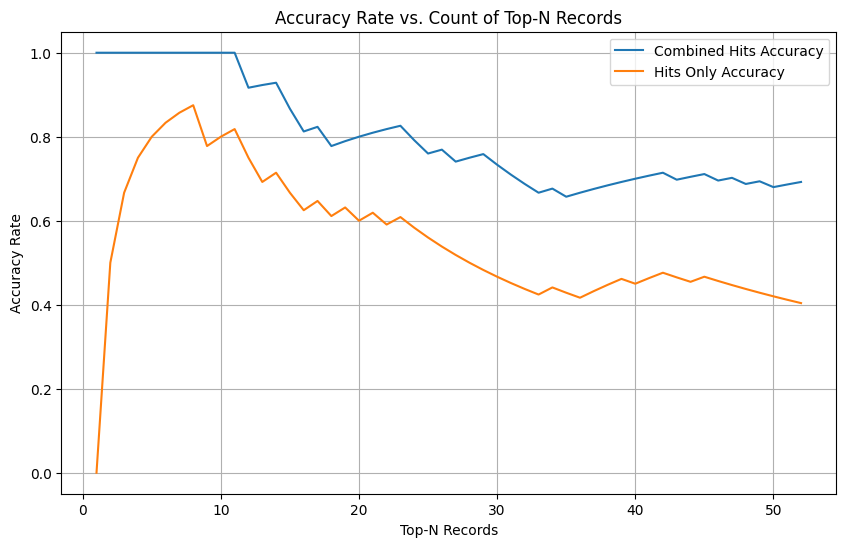

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

mo_50 = pd.read_csv('../data_storage/legislation/MO_weaviate_result_top_50.csv')

mo_50['is_hit'] = mo_50['label'] == 'Y'
mo_50['is_good_hit'] = mo_50['label'] == 'G'
mo_50['cumulative_hits'] = mo_50['is_hit'].cumsum()
mo_50['cumulative_good_hits'] = mo_50['is_good_hit'].cumsum()

# Combined hits and good hits
mo_50['combined_hits'] = mo_50['cumulative_hits'] + mo_50['cumulative_good_hits']

# Calculate total records considered at each n for normalization
mo_50['total_records'] = range(1, len(mo_50) + 1)

# Calculate accuracy rates
mo_50['accuracy_combined'] = mo_50['combined_hits'] / mo_50['total_records']
mo_50['accuracy_hits_only'] = mo_50['cumulative_hits'] / mo_50['total_records']

plt.figure(figsize=(10, 6))
plt.plot(mo_50['total_records'], mo_50['accuracy_combined'], label='Combined Hits Accuracy')
plt.plot(mo_50['total_records'], mo_50['accuracy_hits_only'], label='Hits Only Accuracy')
plt.xlabel('Top-N Records')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy Rate vs. Count of Top-N Records')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
mo_50 = pd.read_csv('../data_storage/legislation/MO_weaviate_result_top_50.csv')
mo_50.groupby('label').count()

,billID,billText,shortBillName,stateBillID,stateCode,statesummary,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90
label,,,,,,,,,,,,,,,,,,,,,
religion,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
without discrimination or segregation HB 2478 because of race,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
G,15,15,15,15,15,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N,12,12,12,12,12,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y,21,21,21,21,21,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
